In [19]:
from tensorflow.keras import layers, optimizers, Model, callbacks, initializers
from tensorflow.keras.constraints import max_norm
from tensorflow import keras
import tensorflow.keras.backend as K
import tensorflow as tf
from pydub import AudioSegment
import matplotlib.pyplot as plt
import threading
import soundfile as sf
from scipy.io import wavfile
import numpy as np
from tqdm import tqdm
from scipy import signal
import subprocess
import math
import shutil
import time
import gc
import random
import os

TRAIN_DATA_PATH = r"..\\data_train"
TEST_DATA_PATH = r"..\\data_test"
TRAIN_DATASET_PATH = r"..\\train_dataset"
TEST_DATASET_PATH = r"..\\test_dataset"

MAX_SAMPLE_FREQUENCY = 256_000

FRAME_SIZE = 4096
FRAME_OVERLAP = 2048

MAXIMUM_NUMBER_OF_NOISE_CHANNELS = 8
NOISE_APLITUDE_MAX = 4
NOISE_FREQ_MAX = 48_000

PRETRAIN_EPOCHS = 1
EPOCHS = 20
STEPES_PER_EPOCH = 5000
BATCH_SIZE = 64

frame_shift = FRAME_SIZE - FRAME_OVERLAP

Loading data

In [20]:
def find_files(files, dirs=[], extensions=[]):
    new_dirs = []
    for d in dirs:
        try:
            new_dirs += [ os.path.join(d, f) for f in os.listdir(d) ]
        except OSError:
            if os.path.splitext(d)[1] in extensions:
                files.append(d)

    if new_dirs:
        find_files(files, new_dirs, extensions)
    else:
        return

In [21]:
file_paths = []
find_files(file_paths, dirs=[TRAIN_DATA_PATH, TEST_DATA_PATH], extensions=[".mp3", ".mp4"])
print(len(file_paths))

# Convert all mp3 files to wav
def convert_all_files():
    for file_path in file_paths:
        cleaned_name = file_path[:-4]

        if file_path[-4:] == ".mp3":
            new_name = cleaned_name + ".wav"

            sound = AudioSegment.from_file(file_path, format="mp3")
            sound.export(new_name, "wav")

            os.remove(file_path)
        elif file_path[-4:] == ".mp4":
            subprocess.Popen(f"ffmpeg -i {file_path} -vn -acodec pcm_s16le -ar 44100 -ac 2 {cleaned_name}.wav").wait()
            os.remove(file_path)

convert_all_files()

0


Process data

In [22]:
def normalization(samples:np.ndarray):
    smpl = samples.copy()
    max_abs_val = max(abs(smpl))

    # Normalization
    smpl /= max_abs_val
    return smpl

In [23]:
def noise_data(data, fs):
  sdata = data.copy()

  length_in_secs = sdata.size / fs
  time = np.linspace(0, length_in_secs, sdata.size, endpoint=False)

  for _ in range(random.randint(1, MAXIMUM_NUMBER_OF_NOISE_CHANNELS)):
    sdata += (random.random() * NOISE_APLITUDE_MAX) * np.cos(2 * np.pi * (random.random() * NOISE_FREQ_MAX) * time + (random.random() * 2 * np.pi))
  
  return sdata

In [24]:
def create_frames(data:np.ndarray):
  number_of_frames = data.size // frame_shift
  frames = [data[idx * frame_shift : FRAME_SIZE + idx * frame_shift] for idx in range(number_of_frames)]
  frames[len(frames) - 1] = np.pad(frames[len(frames) - 1], (0, FRAME_SIZE - frames[len(frames) - 1].shape[0]), "constant")
  return frames

In [25]:
def drawFFT(signal, frequency, idx=None):
  fft = np.fft.fft(signal)

  data_length = len(signal)
  freq = np.arange(data_length)/(data_length/frequency)

  half_length = data_length//2

  freq_one_side = freq[:half_length]
  fft = fft[:half_length]/half_length

  plt.figure(figsize=(18,8))
  plt.title(f"FFT {idx}" if idx is not None else "Generic FFT")
  plt.plot(freq_one_side, abs(fft))
  plt.xlabel('f[Hz]')
  plt.ylabel('Amplituda[-]')
  plt.tight_layout()
  plt.show()

In [26]:
def process_one_file(smpls, fs):
  # Split and normalize
  try:
    if smpls.shape[1] > 0:
      normalized_samples = []

      for i in range(smpls.shape[1]):
        normalized_samples.extend(normalization(smpls[:, i]))

      normalized_samples = np.array(normalized_samples)
    else:
      normalized_samples = normalization(smpls)
  except Exception as e:
    print(f"Exception on spliting data\n{e}")
    normalized_samples = normalization(smpls)

  # Create noised data and normalize them
  noised_samples = noise_data(normalized_samples, fs)
  noised_samples = normalization(noised_samples)

  # plt.figure(figsize=(18,8))
  # plt.plot(np.arange(normalized_samples.size) / fs, normalized_samples)
  # plt.gca().set_xlabel('$t[s]$')
  # plt.gca().set_ylabel('$Amplituda[-]$')
  # plt.show()

  # plt.figure(figsize=(18,8))
  # plt.plot(np.arange(noised_samples.size) / fs, noised_samples)
  # plt.gca().set_xlabel('$t[s]$')
  # plt.gca().set_ylabel('$Amplituda[-]$')
  # plt.show()

  # Power density
  # f1, Pxx1 = signal.periodogram(normalized_samples, fs, scaling="density")
  # print(f1.shape)
  # print(Pxx1.shape)

  # plt.semilogy(f1, Pxx1)
  # plt.title("original")
  # plt.xlabel('f[Hz]')
  # plt.ylabel('PSD [V**2/Hz]')
  # plt.show()

  # f2, Pxx2 = signal.periodogram(noised_samples, fs, scaling="density")
  # print(f2.shape)
  # print(Pxx2.shape)

  # plt.semilogy(f2, Pxx2)
  # plt.title("noised")
  # plt.xlabel('f[Hz]')
  # plt.ylabel('PSD [V**2/Hz]')
  # plt.show()

  # FFT
  # normal_fft = np.fft.fft(normalized_samples)
  # noise_fft = np.fft.fft(noised_samples)

  # print(normal_fft.shape)
  # print(noise_fft.shape)

  # data_length = len(normal_fft)
  # freq = np.arange(data_length)/(data_length/fs)

  # half_length = data_length//2

  # freq_one_side = freq[:half_length]
  # normal_fft = normal_fft[:half_length]/half_length
  # noise_fft = noise_fft[:half_length]/half_length

  # plt.figure(figsize=(18,8))
  # plt.title(f"Normal")
  # plt.plot(freq_one_side, abs(normal_fft))
  # plt.xlabel('f[Hz]')
  # plt.ylabel('Amplituda[-]')
  # plt.tight_layout()
  # plt.show()

  # plt.figure(figsize=(18,8))
  # plt.title(f"Noise")
  # plt.plot(freq_one_side, abs(noise_fft))
  # plt.xlabel('f[Hz]')
  # plt.ylabel('Amplituda[-]')
  # plt.tight_layout()
  # plt.show()

  # Set signals to be between 0 and 1
  normalized_samples += 1
  noised_samples += 1
  normalized_samples = normalization(normalized_samples)
  noised_samples = normalization(noised_samples)

  # plt.figure(figsize=(18,8))
  # plt.plot(np.arange(normalized_samples.size) / fs, normalized_samples)
  # plt.gca().set_xlabel('$t[s]$')
  # plt.gca().set_ylabel('$Amplituda[-]$')
  # plt.show()

  # plt.figure(figsize=(18,8))
  # plt.plot(np.arange(noised_samples.size) / fs, noised_samples)
  # plt.gca().set_xlabel('$t[s]$')
  # plt.gca().set_ylabel('$Amplituda[-]$')
  # plt.show()

  # Create frames
  normalized_samples = create_frames(normalized_samples)
  noised_samples = create_frames(noised_samples)

  # plt.figure(figsize=(18,8))
  # plt.plot(np.arange(normalized_samples[50].size) / fs, normalized_samples[50])
  # plt.gca().set_xlabel('$t[s]$')
  # plt.gca().set_ylabel('$Amplituda[-]$')
  # plt.show()

  # plt.figure(figsize=(18,8))
  # plt.plot(np.arange(noised_samples[50].size) / fs, noised_samples[50])
  # plt.gca().set_xlabel('$t[s]$')
  # plt.gca().set_ylabel('$Amplituda[-]$')
  # plt.show()

  return normalized_samples, noised_samples

Process training data

In [27]:
file_paths = []
find_files(file_paths, dirs=[TRAIN_DATA_PATH], extensions=[".wav"])
print(len(file_paths))

if not os.path.exists(TRAIN_DATASET_PATH):
  os.mkdir(TRAIN_DATASET_PATH)

for file_path in tqdm(file_paths):
  cleaned_name = file_path[:-4].split("\\")[-1]

  if not os.path.exists(f"{TRAIN_DATASET_PATH}/{cleaned_name}"):
    os.mkdir(f"{TRAIN_DATASET_PATH}/{cleaned_name}")

    smpls, f = sf.read(file_path)
    gc.collect()

    print(f"Processing {cleaned_name}")
      
    random.seed()
    norm_s, nois_s = process_one_file(smpls, f)

    offset = len(os.listdir(f"{TRAIN_DATASET_PATH}/{cleaned_name}"))

    for idx, (a, b) in enumerate(zip(norm_s, nois_s)):
      if not os.path.exists(f"{TRAIN_DATASET_PATH}/{cleaned_name}/{idx + offset}_{file_path}"):
        np.save(f"{TRAIN_DATASET_PATH}/{cleaned_name}/{idx + offset}_{f}", np.array([a, b, np.fft.fft(b)]))
  else:
    print(f"Skipping {cleaned_name}")
  gc.collect()

27


  4%|▎         | 1/27 [00:00<00:02,  9.01it/s]

Skipping Y2Mate.is - Can 3 Gamers Beat 1 Trackmania Pro Driving Backwards-DqmSovzS8HY-48k-1639525438813
Skipping Y2Mate.is - CHUNGUS 2 - A very powerful 1Hz Minecraft CPU-FDiapbD0Xfg-128k-1639551674784


  7%|▋         | 2/27 [00:00<00:02,  9.41it/s]

Skipping Y2Mate.is - Dell Made a Framework-G9ZNwKsphEE-160k-1639632198476


 15%|█▍        | 4/27 [00:00<00:02,  9.58it/s]

Skipping Y2Mate.is - Hallelujah - Leonard Cohen [INSANE Piano Cover]-dp6wHzfAH7k-48k-1638725278647
Skipping Y2Mate.is - How to solder components using hot air without them blowing away-gl9NuCiDR7s-48k-1639538474391


 19%|█▊        | 5/27 [00:00<00:02,  9.66it/s]

Skipping Y2Mate.is - How to Wire Up Ethernet Plugs the EASY WAY! (Cat5e  Cat6 RJ45 Pass Through Connectors)-NWhoJp8UQpo-48k-1639516438346


 26%|██▌       | 7/27 [00:00<00:02,  9.53it/s]

Skipping Y2Mate.is - I Challenged 20,000 People to a game of Geoguessr.-8xP9dzxOOGw-128k-1639551233412
Skipping Y2Mate.is - I played a Trackmania tournament where backwards is faster...-U5qP2cB0E7k-48k-1639520188975


 33%|███▎      | 9/27 [00:00<00:01,  9.55it/s]

Skipping Y2Mate.is - I Tried to Improve Your Images...-QyU0rxB7wqI-128k-1639632522354
Processing Y2Mate.is - International Drug Smuggler On How He Beat Airport Security  Minutes With  UNILAD  @LADbible TV-QEPFWgLwrFw-64k-1639550374941


 44%|████▍     | 12/27 [00:45<01:39,  6.63s/it]

Skipping Y2Mate.is - Magnetic dough and fluid...-wRLnwLsdK6A-48k-1639538350175
Skipping Y2Mate.is - Making a bolt with ZIGZAG threads - SO STRANGE! - Lost PLA metal casting-cvi8A2XCK94-160k-1639551618509
Skipping Y2Mate.is - My Chemical Romance - Famous Last Words [Official Music Video] [HD]-8bbTtPL1jRs-48k-1639519742528


 48%|████▊     | 13/27 [00:45<01:05,  4.66s/it]

Processing Y2Mate.is - Panama Canal Toll Fee  How Much Do Ships Pay  Chief MAKOi Seaman Vlog-_FxBBE8DfJI-64k-1639551563045


 59%|█████▉    | 16/27 [01:30<01:30,  8.26s/it]

Skipping Y2Mate.is - Proč Je Tento Havajský Ostrov Pro Veřejnost Uzavřen Více Než 100 Let Zakázaný Ostrov - Niihau-nxzFwbx0i9Q-160k-1639551446148
Skipping Y2Mate.is - rMildlyinfuriating  not mad, just upset-9P0GN03yp54-128k-1639631589682
Skipping Y2Mate.is - Sommelier Shops For Holiday Wines (14 Different Occasions)  World Of Wine  Bon Appétit-eygxbraz9v8-128k-1639551339499


 70%|███████   | 19/27 [01:30<00:23,  2.91s/it]

Skipping Y2Mate.is - Stupid C++ Tricks Most Dangerous C Functions (E02)-B9DouAlkZlc-48k-1639516194897
Skipping Y2Mate.is - The Big Misconception About Electricity-bHIhgxav9LY-160k-1638729545425
Skipping Y2Mate.is - The Biggest Accidents And Injuries On MythBusters-CokW5No-vIU-128k-1639550425817


 81%|████████▏ | 22/27 [01:30<00:05,  1.07s/it]

Skipping Y2Mate.is - The Elder Scrolls Online After 1000 Hours-ECoXQjFFr7s-160k-1639551763030
Skipping Y2Mate.is - These TikTok ‘’Musicians’’ Need to STOP-CIhzQIFmZTI-48k-1639529539528
Skipping Y2Mate.is - Trick Your Sense Of Taste In 5 Different Ways-6pTv-2XPBl4-48k-1639529673526


 93%|█████████▎| 25/27 [01:31<00:00,  2.30it/s]

Skipping Y2Mate.is - Watch Escapement Desk Toy-RcnWL6_6Xu4-96k-1639551819659
Skipping Y2Mate.is - When you accidentally write theme songs that already exist-K-sGekaaGJA-48k-1639515859068
Skipping Y2Mate.is - Why Ernest Wright Scissors Are So Expensive  So Expensive-bK4AWtTV3h4-48k-1639529628215


100%|██████████| 27/27 [01:31<00:00,  3.39s/it]

Skipping Y2Mate.is - Youtuberku šikanovali na internetu. Skončilo to fatálně - WoLe #175-jLjNquL1HbY-128k-1639631444498


Process testing data

In [28]:
file_paths = []
find_files(file_paths, dirs=[TEST_DATA_PATH], extensions=[".wav"])
print(len(file_paths))

if not os.path.exists(TEST_DATASET_PATH):
  os.mkdir(TEST_DATASET_PATH)

for file_path in tqdm(file_paths):
  cleaned_name = file_path[:-4].split("\\")[-1]

  if not os.path.exists(f"{TEST_DATASET_PATH}/{cleaned_name}"):
    os.mkdir(f"{TEST_DATASET_PATH}/{cleaned_name}")

    smpls, f = sf.read(file_path)
    gc.collect()

    print(f"Processing {cleaned_name}")
      
    random.seed()
    norm_s, nois_s = process_one_file(smpls, f)

    offset = len(os.listdir(f"{TEST_DATASET_PATH}/{cleaned_name}"))

    for idx, (a, b) in enumerate(zip(norm_s, nois_s)):
      if not os.path.exists(f"{TEST_DATASET_PATH}/{cleaned_name}/{idx + offset}_{file_path}"):
        np.save(f"{TEST_DATASET_PATH}/{cleaned_name}/{idx + offset}_{f}", np.array([a, b, np.fft.fft(b)]))
  else:
    print(f"Skipping {cleaned_name}")
  gc.collect()

9


 11%|█         | 1/9 [00:00<00:00,  8.62it/s]

Skipping Y2Mate.is - 15 Biggest And Most Expensive Mining FINDS-GAwIKLthp-U-48k-1639522068716
Skipping Y2Mate.is - Chernobyl (2019) - It's not 3 Roentgen it is 15000 scene.-yPRMx2k1NM8-128k-1639552069014


 22%|██▏       | 2/9 [00:00<00:00,  8.99it/s]

Skipping Y2Mate.is - CHUNGUS 2 - A very powerful 1Hz Minecraft CPU-FDiapbD0Xfg-160k-1639551674263


 44%|████▍     | 4/9 [00:00<00:00,  9.12it/s]

Skipping Y2Mate.is - I Challenged 20,000 People to a game of Geoguessr.-8xP9dzxOOGw-64k-1639551249719
Skipping Y2Mate.is - Making a bolt with ZIGZAG threads - SO STRANGE! - Lost PLA metal casting-cvi8A2XCK94-64k-1639551619488


 56%|█████▌    | 5/9 [00:00<00:00,  9.11it/s]

Skipping Y2Mate.is - Proč Je Tento Havajský Ostrov Pro Veřejnost Uzavřen Více Než 100 Let Zakázaný Ostrov - Niihau-nxzFwbx0i9Q-96k-1639551444666


 78%|███████▊  | 7/9 [00:00<00:00,  9.13it/s]

Skipping Y2Mate.is - Sommelier Shops For Holiday Wines (14 Different Occasions)  World Of Wine  Bon Appétit-eygxbraz9v8-160k-1639551332303
Skipping Y2Mate.is - The Big Misconception About Electricity-bHIhgxav9LY-128k-1639551389489


 89%|████████▉ | 8/9 [00:00<00:00,  9.22it/s]

Skipping Y2Mate.is - Watch Escapement Desk Toy-RcnWL6_6Xu4-160k-1639551826187


100%|██████████| 9/9 [00:00<00:00,  9.15it/s]


Data generator

In [29]:
def convert_imag_to_parts(array:np.ndarray):
    tmp = np.empty((array.shape[0], 2))

    for idx, a in enumerate(array):
        tmp[idx][0] = a.real
        tmp[idx][1] = a.imag

    return np.nan_to_num(tmp)

class DataGenerator(keras.utils.Sequence, threading.Thread):
    def __init__(self, path, dim, batch_size=32, shuffle=True):
        super(DataGenerator, self).__init__()

        self.dim = dim
        self.files = []
        find_files(self.files, dirs=[path], extensions=[".npy"])

        self.batch_size = batch_size
        self.shuffle = shuffle

        self.queue = []

        self.length = int(np.floor(len(self.files) / self.batch_size))
        self.index = 0
        self.daemon = True
        self.__terminate = False;
        self.shuffle_data()
        self.start()

    def __del__(self):
        self.__terminate = True

    def __len__(self):
        return self.length

    def run(self) -> None:
        while True:
            if self.__terminate: break

            if len(self.queue) < 20:
                if (self.index + 1) >= self.length:
                    self.shuffle_data()
                    self.index = 0

                files = self.files[self.index*self.batch_size:(self.index+1)*self.batch_size]
                self.index += 1

                # Generate data
                data = self.__data_generation(files)
                if data is not None:
                    self.queue.append(data)
            else: time.sleep(0.1)

    def __getitem__(self, _):
        while len(self.queue) == 0: time.sleep(0.01)
        return self.queue.pop()

    def shuffle_data(self):
        if self.shuffle == True:
            np.random.shuffle(self.files)

    def on_epoch_end(self):
        pass

    def __data_generation(self, files):
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        fft = np.empty((self.batch_size, self.dim[0], 2))
        f = np.empty((self.batch_size), dtype=float)
        y = np.empty((self.batch_size, *self.dim))

        # Generate data
        for idx, file in enumerate(files):
            freq = float(file[:-4].split("_")[-1])
            loaded_data = np.load(file)

            try:
                X[idx,] = loaded_data[1].real
                fft[idx,] = convert_imag_to_parts(loaded_data[2])
                f[idx] = freq / MAX_SAMPLE_FREQUENCY
                y[idx,] = loaded_data[0].real
            except Exception as e:
                print(f"Failed to process {file}\n{e}")
                return None

        return [X, fft, f], y

Model

In [30]:
max_norm_value = 2.0

def create_model():
  inp1 = layers.Input(shape=(FRAME_SIZE,1), name="Frame Input")
  inp2 = layers.Input(shape=(FRAME_SIZE,2), name="FFT Input")
  inp3 = layers.Input(shape=(1,), name="Frequency Input")

  y = layers.Dense(FRAME_SIZE)(inp3)
  y = layers.LeakyReLU(0.2)(y)
  y = layers.Dropout(0.1)(y)
  y = layers.Reshape((FRAME_SIZE, 1))(y)

  x = layers.concatenate([inp1, inp2, y])

  # Encoder
  x = layers.Conv1D(256, kernel_size=3, strides=2, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
  x1 = layers.LeakyReLU(0.2)(x)

  x = layers.Conv1D(128, kernel_size=3, strides=2, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x1)
  x2 = layers.LeakyReLU(0.2)(x)

  x = layers.Conv1D(64, kernel_size=3, strides=2, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x2)
  x3 = layers.LeakyReLU(0.2)(x)
  
  # Encoded value

  # Edecoder
  x = layers.Conv1D(64, kernel_size=3, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x3)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Add()([x, x3])

  x = layers.Conv1D(64, kernel_size=3, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
  x = layers.UpSampling1D(2)(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Conv1D(128, kernel_size=3, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Add()([x, x2])

  x = layers.Conv1D(128, kernel_size=3, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
  x = layers.UpSampling1D(2)(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Conv1D(256, kernel_size=3, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Add()([x, x1])

  x = layers.Conv1D(256, kernel_size=3, padding="same", kernel_constraint=max_norm(max_norm_value), kernel_initializer=initializers.RandomNormal(stddev=0.02))(x)
  x = layers.UpSampling1D(2)(x)
  x = layers.LeakyReLU(0.2)(x)

  # Output
  x = layers.Conv1D(1, kernel_size=1, kernel_constraint=max_norm(max_norm_value), activation='sigmoid', padding='same')(x)
  return Model([inp1, inp2, inp3], x)

In [31]:
train_data_generator = DataGenerator(TRAIN_DATASET_PATH, (FRAME_SIZE,), BATCH_SIZE)
test_data_generator = DataGenerator(TEST_DATASET_PATH, (FRAME_SIZE,), BATCH_SIZE)

print(len(train_data_generator))
print(len(test_data_generator))

13659
4413


Training

In [32]:
def noiseToSignalLoss(y_true, y_pred):
    losses = tf.math.divide(tf.math.reduce_sum(tf.math.pow(tf.math.abs(tf.math.subtract(y_true,y_pred)),2)),
                            tf.math.reduce_sum(tf.math.pow(tf.math.abs(y_true),2)))
    return tf.reduce_mean(losses)

In [33]:
def SNR(y_true, y_pred):
  return -10.0 * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.0)

In [34]:
model = create_model()
model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)
print(model.input_shape)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Frequency Input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 4096)         8192        ['Frequency Input[0][0]']        
                                                                                                  
 leaky_re_lu_10 (LeakyReLU)     (None, 4096)         0           ['dense_1[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 4096)         0           ['leaky_re_lu_10[0][0]']         
                                                                                            

In [35]:
# model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=["accuracy"])
model.compile(optimizer=optimizers.Adam(1e-4, 0.5), loss=noiseToSignalLoss, metrics=[SNR])
# model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss="mse", metrics=["accuracy"])

In [36]:
number_of_batches = len(train_data_generator) // STEPES_PER_EPOCH

try:
  if os.path.exists("weights.h5"):
    model.load_weights("weights.h5")
  else:
    print("Starting pretrain")
    model.fit(train_data_generator, steps_per_epoch=STEPES_PER_EPOCH, epochs=PRETRAIN_EPOCHS * number_of_batches, callbacks=[callbacks.TensorBoard("logs/pretraining")])

  print("Starting training")
  model.fit(train_data_generator, steps_per_epoch=STEPES_PER_EPOCH, epochs=EPOCHS * number_of_batches,
            callbacks=[callbacks.ReduceLROnPlateau(monitor='val_loss',patience=10,factor=0.5,verbose=1), callbacks.TensorBoard("logs/training"), callbacks.ModelCheckpoint("model_checkpoint", monitor="val_PSNR", verbose=1, save_best_only=True, mode="max")],
            validation_data=test_data_generator, validation_steps=(STEPES_PER_EPOCH // 4) if STEPES_PER_EPOCH is not None else None)
except KeyboardInterrupt:
  model.save_weights("weights.h5")

Starting pretrain
Epoch 1/2
5000/5000 [==============================] - 1147s 223ms/step - loss: 0.0098 - PSNR: 26.1530
Epoch 2/2
4081/5000 [=======================>......] - ETA: 4:38 - loss: 0.0074 - PSNR: 27.3592

In [ ]:
model.save("model.h5", include_optimizer=False, save_format="h5")

Predictions

In [ ]:
def denoise(sample, fs):
  number_of_frames = sample.size // FRAME_SIZE
  frames = [sample[idx * FRAME_SIZE : FRAME_SIZE + idx * FRAME_SIZE] for idx in range(number_of_frames)]

  frames = np.array(frames)

  fft = np.array([convert_imag_to_parts(np.fft.fft(frame)) for frame in frames])

  output_frames = model.predict([frames, fft, np.ones((frames.shape[0], 1)) * fs])

  final_frame = None
  
  for frame in output_frames:
    frame = np.reshape(frame, (FRAME_SIZE,))

    if final_frame is None:
      final_frame = frame
    else:
      final_frame = np.concatenate([final_frame, frame], axis=0)

  return final_frame

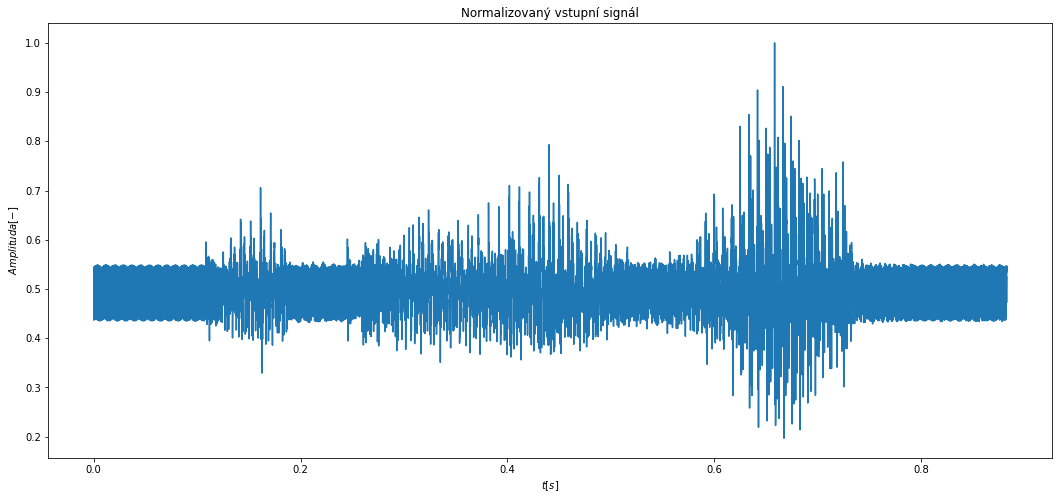

(16384,)


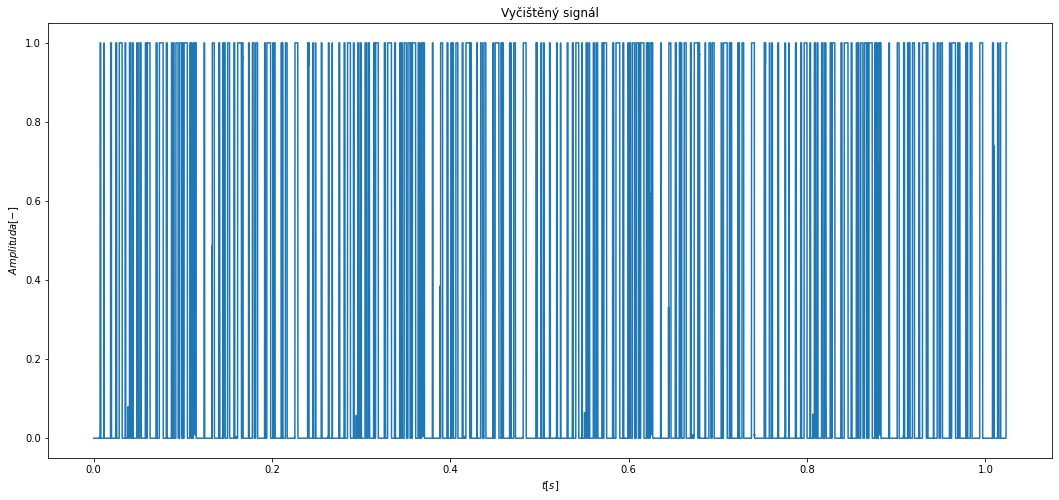

In [ ]:
samples_orig, sample_freq = sf.read("../audio/xdousa00.wav")

samples_normal = normalization(samples_orig) + 1
samples_normal = normalization(samples_normal)

plt.figure(figsize=(18,8))
plt.title("Normalizovaný vstupní signál")
plt.plot(np.arange(samples_normal.size) / sample_freq, samples_normal)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_ylabel('$Amplituda[-]$')
plt.show()

cleared_signal = denoise(samples_normal, sample_freq)
norm_cleared_signal = normalization(cleared_signal)

print(norm_cleared_signal.shape)

plt.figure(figsize=(18,8))
plt.title("Vyčištěný signál")
plt.plot(np.arange(norm_cleared_signal.size) / sample_freq, norm_cleared_signal)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_ylabel('$Amplituda[-]$')
plt.show()

wavfile.write("clean_test.wav", sample_freq, norm_cleared_signal)

Cleanup

In [ ]:
if input("Are you sure you want to delete datasets?\n") == "y":
  shutil.rmtree(TRAIN_DATASET_PATH)
  shutil.rmtree(TEST_DATASET_PATH)